# 텍스트 데이터 다루기

## 1. 단어와 문자의 원-핫 인코딩


In [1]:
# 단어 수준의 원-핫 인코딩하기
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            # 단어마다 고유한 인덱스를 할당
            # 인덱스 0은 사용하지 않음
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples), max_length,
                   max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [2]:
# 문자 수준 원-핫 인코딩하기
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [3]:
# 케라스를 사용한 단어 수준의 원-핫 인코딩하기
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

9개의 고유한 토큰을 찾았습니다.


In [4]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## 2. 단어 임베딩 사용하기


In [5]:
# Embedding 층에 사용할 IMDB 데이터 로드하기
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.data_utils.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.data_utils.pad_sequences(x_test, maxlen=maxlen)

In [6]:
x_train

array([[  65,   16,   38, ...,   19,  178,   32],
       [  23,    4, 1690, ...,   16,  145,   95],
       [1352,   13,  191, ...,    7,  129,  113],
       ...,
       [  11, 1818, 7561, ...,    4, 3586,    2],
       [  92,  401,  728, ...,   12,    9,   23],
       [ 764,   40,    4, ...,  204,  131,    9]], dtype=int32)

In [7]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-06-06 23:57:37.051843: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - 7s 11ms/step - loss: 0.6718 - acc: 0.6142 - val_loss: 0.6255 - val_acc: 0.6978
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5498 - acc: 0.7452 - val_loss: 0.5310 - val_acc: 0.7302
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4646 - acc: 0.7883 - val_loss: 0.5017 - val_acc: 0.7478
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4211 - acc: 0.8094 - val_loss: 0.4944 - val_acc: 0.7532
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3916 - acc: 0.8267 - val_loss: 0.4926 - val_acc: 0.7564
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3675 - acc: 0.8387 - val_loss: 0.4963 - val_acc: 0.7572
Epoch 7/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3467 - acc: 0.8500 - val_loss: 0.5004 - val_acc: 0.7558
Epoch 8/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3275 - acc

## 3. 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

### 3.1. 원본 IMDB 텍스트 내려받기

In [8]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 3.2. 데이터 토큰화

In [9]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import data_utils
import numpy as np


maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = data_utils.pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


### 3.3. 임베딩 전처리

In [10]:
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [11]:
# GloVe 단어 임베딩 행렬 준비하기
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 3.4. 모델 정의하기

In [12]:
# 모델 정의하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 3.5. 모델에 GloVe 임베딩 로드하기

In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 3.6. 모델 훈련과 평가

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 254ms/step - loss: 1.8915 - acc: 0.5000 - val_loss: 0.7771 - val_acc: 0.5089
Epoch 2/10
7/7 [==============================] - 1s 195ms/step - loss: 0.6026 - acc: 0.6550 - val_loss: 0.7146 - val_acc: 0.5217
Epoch 3/10
7/7 [==============================] - 1s 192ms/step - loss: 0.4416 - acc: 0.8450 - val_loss: 0.9230 - val_acc: 0.5088
Epoch 4/10
7/7 [==============================] - 1s 195ms/step - loss: 0.4078 - acc: 0.7800 - val_loss: 1.0805 - val_acc: 0.5088
Epoch 5/10
7/7 [==============================] - 1s 194ms/step - loss: 0.3073 - acc: 0.8600 - val_loss: 0.7149 - val_acc: 0.5628
Epoch 6/10
7/7 [==============================] - 1s 191ms/step - loss: 0.1790 - acc: 0.9400 - val_loss: 0.7958 - val_acc: 0.5331
Epoch 7/10
7/7 [==============================] - 1s 194ms/step - loss: 0.0991 - acc: 1.0000 - val_loss: 1.2049 - val_acc: 0.5005
Epoch 8/10
7/7 [==============================] - 1s 197ms/step - loss: 0.1097 - acc: 0.99

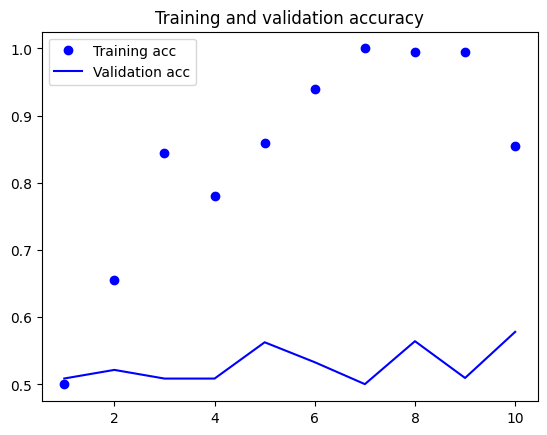

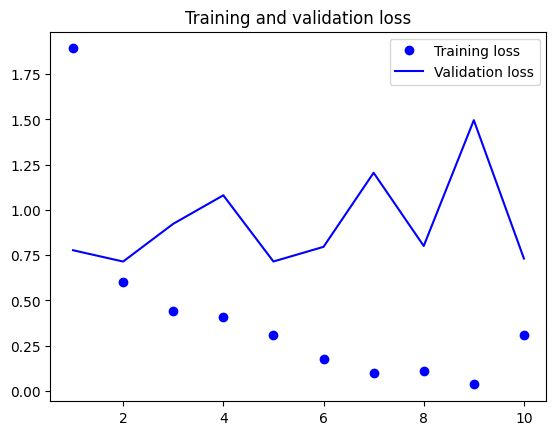

In [15]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 274ms/step - loss: 0.6979 - acc: 0.4550 - val_loss: 0.6928 - val_acc: 0.5071
Epoch 2/10
7/7 [==============================

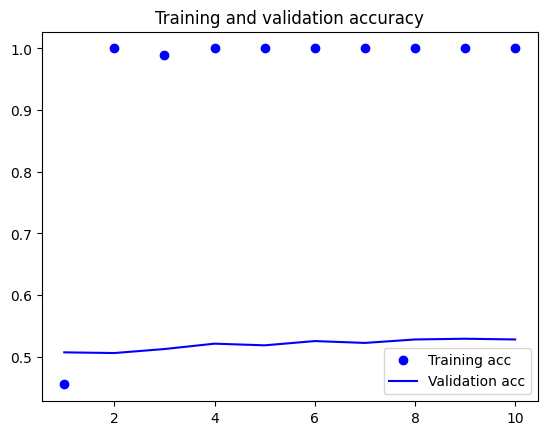

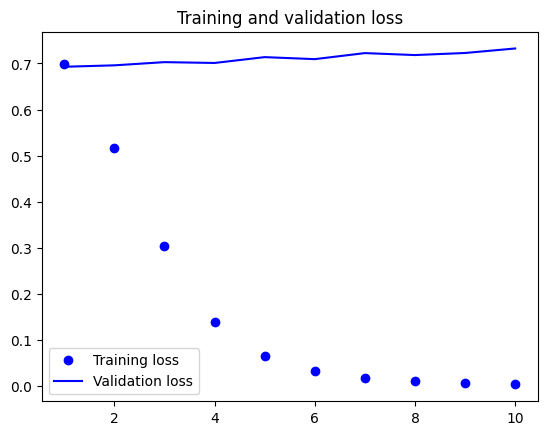

In [17]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# 샘플 개수를 20000개 사용할 경우
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                320032    
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 5s 65ms/step - loss: 0.6823 - acc: 0.5685 - val_loss: 0.6508 - val_acc: 0.6587
Epoch 2/10
63/63 [===========================

In [19]:
# 테스트 데이터 토근화하기
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = data_utils.pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [20]:
# 테스트 세트에서 모델 평가하기
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.7365 - acc: 0.5718


[0.7364580631256104, 0.5718399882316589]